# S2DS gophr - Model 1 implementation
### Predicting the likelihood of a job being accepted by any courier in the pool of couriers.

In [1]:
# package import
import numpy as np
import pandas as pd
pd.options.display.max_columns = None 
pd.options.display.max_rows = None
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 1.4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 12
%config InlineBackend.figure_format = "retina"
# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
# from source-tree
import utils
import data
import features
import models
%load_ext autoreload
%autoreload 2

## 1 Import dataset and generate features

In [ ]:
# Clean, merge and save the dataset
#data.clean_merge_and_save('jobs.feather','weather.feather', 'df_clean_jobs.feather') 

In [4]:
# load the cleaned dataset from the data folder
df = pd.read_feather(utils.path_to('data', 'final', 'df_clean_jobs.feather'))

# generate features
df, feature_names  = features.generate_features(df)

# extract feature set and remove curropt feature 'courier_earnings_calc_log'
df_model = df[feature_names].copy()
df_model.drop('courier_earnings_calc_log', axis=1, inplace=True)

Timed categorising: earliest_pickup_time
Timed categorising: delivery_deadline
Unchanged features: show_on_board, is_first_war_job, temp, feels_like, humidity, wind_speed, clouds_all, is_daytime
Engineering individual features
Log transforming: distance, initial_time_buffer, estimated_journey_time, courier_earnings_calc, size_min, size_med, size_max, weight, volume, size_min_max
Minimum of initial_time_buffer is less or equal to 0: -12839.0, adding constant of 12840.0 prior to log.
Minimum of courier_earnings_calc is less or equal to 0: -5904.46, adding constant of 5905.46 prior to log.
One hot encoding: is_food, is_fragile, is_liquid, is_not_rotatable, is_glass, is_baked, is_flower, is_alcohol, is_beef, is_pork
One hot encoding: vehicle_type, job_priority, weather_cats, earliest_pickup_time_month, earliest_pickup_time_day, earliest_pickup_time_hour, pickup_zone, delivery_zone
Cyclic encoding: earliest_pickup_time
Cyclic encoding: delivery_deadline


## 2 Split data for training and testing

In [7]:
# split data into a train and test dataset
X_train, X_test, y_train, y_test = models.split_data(X=df_model, 
                                                     y=df['is_rejected'],
                                                     test_size=0.25)

# oversample minortiy class with the ADASYN algorthim
X_train_os, y_train_os = models.oversample_ADASYN(X=X_train,
                                            y=y_train, 
                                            ratio=0.075)

Train size:   104208
Test size:     34737
Minority-ratio  1.0%
Features:        109
Oversampled minority-ratio of: 7.0%


## 3 Predictive modeling

### 3.1 Fit Logistic Regression

In [6]:
# run default Logistic Regression
clf_lr_default = LogisticRegression(max_iter=1200).fit(X_train_os, y_train_os)

# evaulate the model performance
models.eval_model_performance(y_test, X_test, clf_lr_default, name='Logistic Regression default')

/Users/felixschrank/anaconda3/envs/s2ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,precision,recall,fscore,sensitivity,specificity,TN,FP,FN,TP,AUC
Logistic Regression default,0.0,0.0,0.0,0.0,0.999942,34398,2,337,0,0.822481


In [28]:
# save model
models.save_model(clf_lr_default, 'clf_lg_model_1.bin')

Saved: <class 'sklearn.linear_model._logistic.LogisticRegression'>.


### 3.2 Fit XGBoost 

In [9]:
# run default XGBoost
clf_xgb_default = xgb.XGBClassifier().fit(X_train_os, y_train_os)

# run XGBoost with optimzed hyperparameter
clf_xgb_tuned = models.Xgb().fit(X_train_os, y_train_os)

# evaluate model performance
models.eval_model_performance(y_test, X_test, clf_xgb_default, clf_xgb_tuned,
                              name=['XGB default','XGB tuned'])

,precision,recall,fscore,sensitivity,specificity,TN,FP,FN,TP,AUC
XGB default,0.391304,0.026706,0.050000,0.026706,0.999593,34386,14,328,9,0.844003
XGB tuned,0.200000,0.005935,0.011527,0.005935,0.999767,34392,8,335,2,0.845468


In [15]:
# save a model
models.save_model(clf_xgb_default, 'clf_xgb_model_1.bin')

Saved: <class 'xgboost.sklearn.XGBClassifier'>.


#### XGB hyperparaemter tuning

In [ ]:
# find booster-limits
cv_test = models.Xgb()
cv_test.fit_xgb_cv(X_train, y_train)

In [105]:
# XGB with gridsearchCV to find optimal hyperparameter
parameter_grid_xgb = {'max_depth': [7],
                    'learning_rate': [0.05],
                    'min_child_weight': [0.4],
                    'gamma': [0.01],
                    'subsample': [1],
                    'colsample_bytree': [1],
                    'reg_lambda':1,
                    'reg_alpha': [0.01],
                    'scale_pos_weight':1,
                    'n_estimators':40}

gs_xgb = models.Xgb()
gs_xgb.gridsearch_fit(X_train, y_train, parameter_grid_xgb)

Fitting 4 folds for each of 243 candidates, totalling 972 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  4.7min
[Parallel(

Best parameters found:
 {'colsample_bytree': 1, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.4, 'n_estimators': 40, 'objective': 'binary:logistic', 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'silent': False, 'subsample': 1}


## 4 Model evaluation

In [16]:
# load models
clf_xgb_tuned = models.load_model('clf_xgb_model_1.bin')
clf_lr_default = models.load_model('clf_lg_model_1.bin')

Loaded: <class 'xgboost.sklearn.XGBClassifier'>.
Loaded: <class 'sklearn.linear_model._logistic.LogisticRegression'>.


In [17]:
# evaluate model performance
models.eval_model_performance(y_test, X_test, clf_lr_default, clf_xgb_tuned,
                              name=['Logistic Regression', 'XGBoost'])

,precision,recall,fscore,sensitivity,specificity,TN,FP,FN,TP,AUC
Logistic Regression,0.000000,0.000000,0.00,0.000000,0.999884,34396,4,337,0,0.818092
XGBoost,0.391304,0.026706,0.05,0.026706,0.999593,34386,14,328,9,0.844003


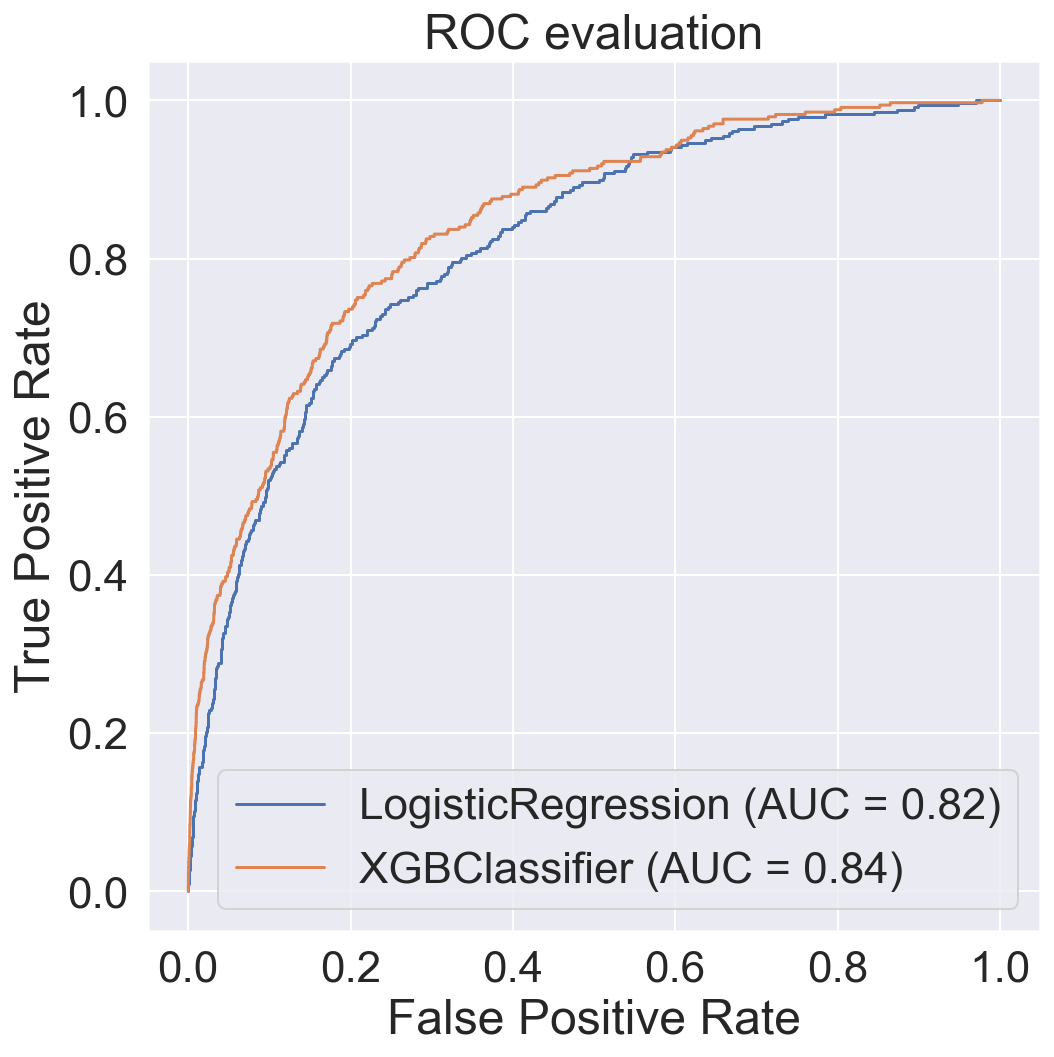

In [18]:
from sklearn.metrics import plot_roc_curve

# plot ROC curves
fig, ax = plt.subplots(figsize=(8,8))
plot_roc_curve(clf_lr_default, X_test, y_test, ax=ax)
plot_roc_curve(clf_xgb_tuned, X_test, y_test, ax=ax)
plt.title('ROC evaluation')
plt.show()

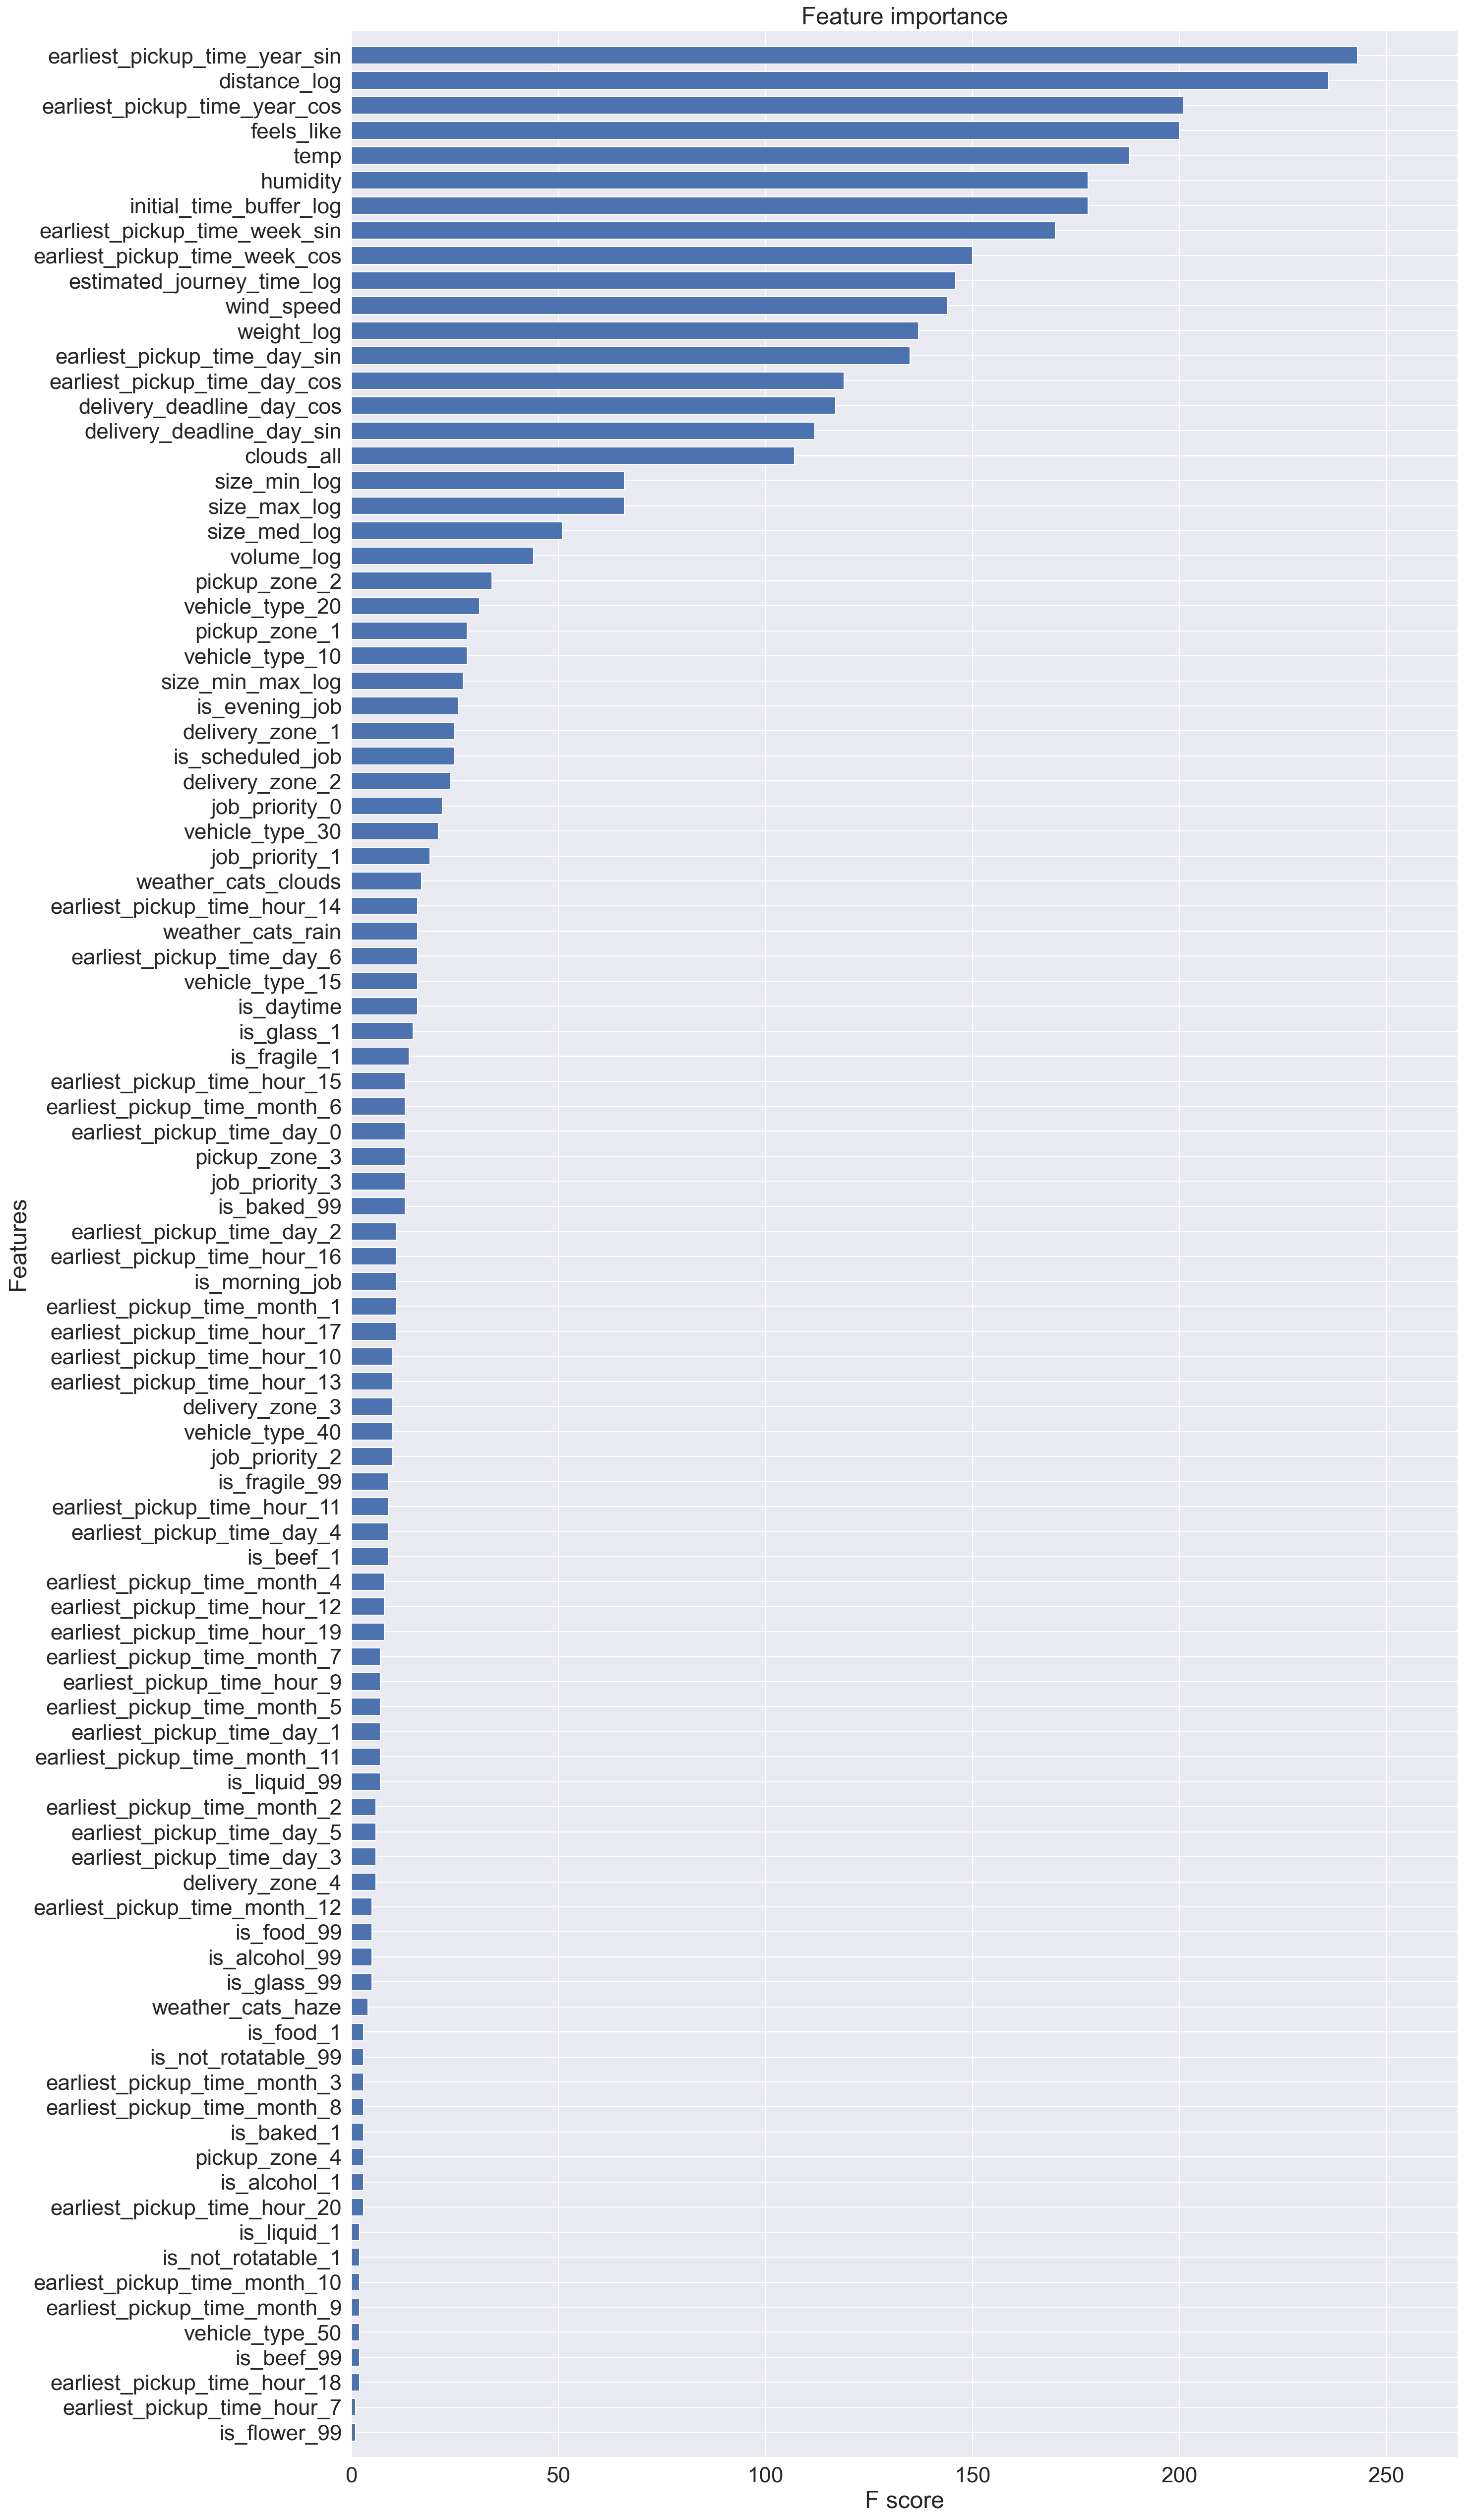

In [19]:
# Plot feature importance
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 2)
fig, ax = plt.subplots(figsize=(20,45))
xgb.plot_importance(clf_xgb_default, show_values=False, height=.7, ax=ax)
plt.show() 